# Research Skills: Image Analysis 
## Take-home Assignment - Part 2 
Sharon Ong, Department of Cognitive Science and Artificial Intelligence 

Tilburg University
Blok 3, Spring 2024

Your First Name: Leonard

Your Last Name: Sugg

Your Student ID: 2039830

Please include any special instructions to run your code, references to any code, methods, ideas that are not your own or not provided in this course here. 

## Part 2: Processing an image of coins

1. (2 points) Load the image of coins you have been provided and display it with an appropriate title.

In [1]:
#Your code goes here 
#Imports
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks, probabilistic_hough_line
from skimage import io, color, exposure, segmentation,util,filters,feature
import numpy as np
import matplotlib.pylab as plt
from skimage.filters import median,sobel, prewitt_v, prewitt_h, prewitt,rank
import scipy.ndimage
from skimage.draw import circle_perimeter
from skimage.util import img_as_float, img_as_ubyte
from skimage.future import graph
from skimage.feature import match_template, peak_local_max
from skimage.measure import label, regionprops
from skimage.morphology import extrema,reconstruction,skeletonize, thin, disk, square, opening, dilation, erosion, closing, white_tophat, binary_dilation, binary_erosion, binary_opening, binary_closing
from skimage.color import label2rgb, gray2rgb
import math
from skimage.segmentation import watershed
from scipy import ndimage
# Save plots in notebook
%matplotlib inline
#Creating normaliser function
def normali(array):
    result=(array - np.amin(array))*255.0 /(np.amax(array)-np.amin(array)) 
    return result

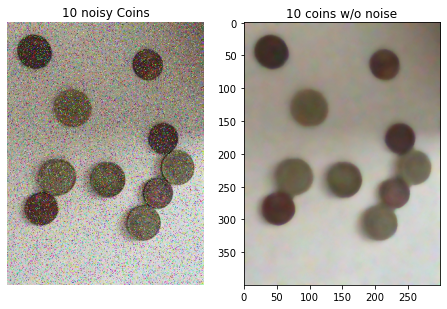

In [2]:
#loading picture
im_og=io.imread('2039830_coinimage.jpg')
im_og= (im_og - np.amin(im_og)) /(np.amax(im_og)-np.amin(im_og)) 
#Displaying picture
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(im_og)
plt.title('10 noisy Coins')
plt.axis('off')

# Apply median filter to each channel of the RGB image
r_channel = median(im_og[:, :, 0], disk(7))
g_channel = median(im_og[:, :, 1], disk(7))
b_channel = median(im_og[:, :, 2], disk(7))
# Combine the filtered channels into a single RGB image
#Chatgpt helped for this method
im_color = np.stack((r_channel, g_channel, b_channel), axis=-1)

#Displaying clean picture
plt.subplot(1,3,2)
plt.imshow(im_color)
plt.title("10 coins w/o noise")
#plt.axis('off')
plt.show()




[[-1. -1. -1. -1. -1. -1. -1.]
 [-1. 20. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]]


/tmp/ipykernel_4618/469391984.py:23: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Lap = scipy.ndimage.filters.convolve(im, kernel)


(-0.5, 299.5, 399.5, -0.5)

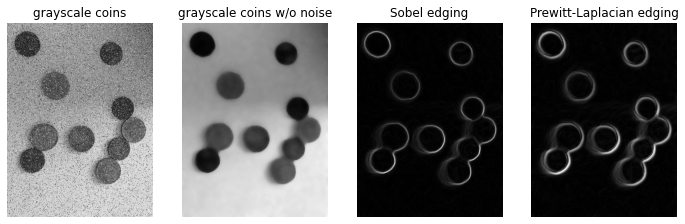

In [3]:
#Preprocessing grayscale
#converting to grayscale
im_gray=color.rgb2gray(im_og)
plt.figure(figsize=(12,8))
plt.subplot(1,4,1)
plt.imshow(im_gray,cmap='gray')
plt.title("grayscale coins")
plt.axis('off')
#Replacing each pixel with its median values in a 7x7 kernel to remove noise
im=median(im_gray, disk(7))
plt.subplot(1,4,2)
plt.imshow(im,cmap='gray')
plt.title("grayscale coins w/o noise")
plt.axis('off')

# Kernel for Laplacian: 
size=7 
kernel = np.ones((size,size))*(-1) 
kernel[1,1] = 20 
#kernel[size-2,size-2]=30 didn't work well
print(kernel)
# Convolution of the image with the kernel: 
Lap = scipy.ndimage.filters.convolve(im, kernel) 
Lap_p=prewitt(Lap)
#applying sobel
plt.subplot(1,4,3)
plt.imshow(sobel(im),cmap="gray")
plt.title("Sobel edging")
plt.axis('off')
#applying prewitt
plt.subplot(1,4,4)
plt.imshow(Lap_p,cmap='gray')
plt.title("Prewitt-Laplacian edging")
plt.axis('off')


2. (20 points) SSegment the coins to obtain a binary image where pixels representing the coins are set to 1.
You should compare two dierent image segmentation algorithms and you can apply image enhancement
techniques and morphological operations on these imagese..

   **Report the steps you took to compute two image segmentation algorithms as comments in your code. Display the results of image processing at each step with appropriate title

Possible segmentation techniques include Thresholding, Edge Detection, Hough Transforms, Superpixels 
and Graphcuts. Comparing two thresholding algorithms only count as 1 method. The morphologica 
operations are seen as pre or post processing operations. You can combine different techniques. F r
example, you can combine Thresholding with morphological operations and histogram equalization as
one solution and Edge detection followed by morphological operations as another solution.s.**

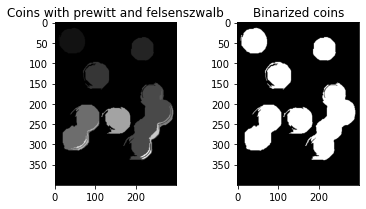

In [4]:
#Superpixel approach
#Applying felsenszwalb algorithm
segments_fz1 = segmentation.felzenszwalb(Lap_p, scale=3000, sigma=1, min_size=100)
# add 1 to avoid labels with 0
segments_fz1 = segments_fz1+1 
#Visualizing
plt.figure(figsize=(12,8))
plt.subplot(1,4,1)
plt.imshow(segments_fz1,cmap='gray')
plt.title('Coins with prewitt and felsenszwalb')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
#Binarizing segments_fz1
plt.subplot(1,4,2)
im_bi=np.where(segments_fz1<2,0,1)
plt.imshow(im_bi,cmap='gray')
plt.title('Binarized coins')
plt.subplots_adjust(wspace=0.5, hspace=0.5)

(-0.5, 299.5, 399.5, -0.5)

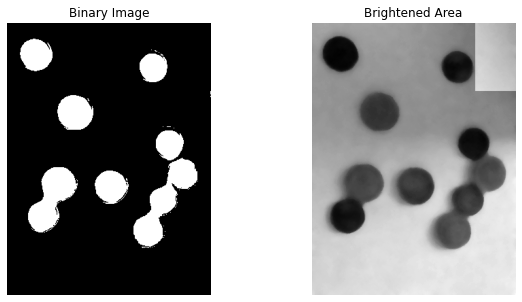

In [5]:
#Thresholding approach
#Removing dark area in top right corner
#Starting coordinates of the region
x_start, y_start = 240, 0 
#Width and height of the region
width, height = 60, 100   
#Increase pixel intensities by 0.25
brightness_increment = 0.25  

#Modify pixel intensities within the specified region
#Chatgpt helped with the syntax and debugging
im[y_start:y_start+height, x_start:x_start+width] += brightness_increment

#Ensure pixel values remain within the valid range [0, 255]
brightened_image = np.clip(im, 0, 255)
#Combining normalized Laplacian edges and brightened image
comb_bright_Lap=(brightened_image+Lap_p/Lap_p.max()).astype(float)
#Binarizing combination
im_bi2=np.where(comb_bright_Lap>0.5,0,1)
#Display the brightened image and binary image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im_bi2, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(brightened_image, cmap='gray')
plt.title('Brightened Area')
plt.axis('off')



3. (5 points) Sets of white pixels which are connected to each other are called connected components or objects. Using your best segmentation result from Q2A.2, create code to connect all the connected 
components and visualize each connected component with a dierent color overlaid on the original image*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Labeled Objects with Skeleton Overlay')

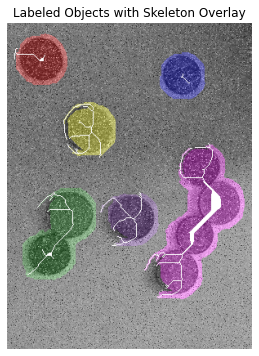

In [6]:
# Sample answer from the practical, skeletionize the binary picture and thin it 
skeleton = skeletonize(im_bi)
thinned = thin(im_bi)
# partial thinning for 29 interations
thinned_partial = thin(im_bi, max_num_iter=29)
#Set block size
block_size = 101
#Threshold locally and save as new variable
imbw = im_bi > filters.threshold_local(im, block_size, method='mean')
#Create and overlay labels
label_img = label(imbw)
image_label_overlay = label2rgb(label_img, image=im_og, bg_label=0)

#Convert thinned_partial to color for overlay
color_skel = gray2rgb(thinned_partial)

# Display labeled objects with skeleton overlay
plt.figure(figsize=(14,6))
plt.imshow(image_label_overlay + color_skel)
plt.axis('off')
plt.title('Labeled Objects with Skeleton Overlay')


4. (10 points) Using your best segmentation result from Q2A.2, separate the touching coins and visualize each coin with a dierent color overlaid on the original image. Report the steps you took as comments in your code.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Coin separated on og image')

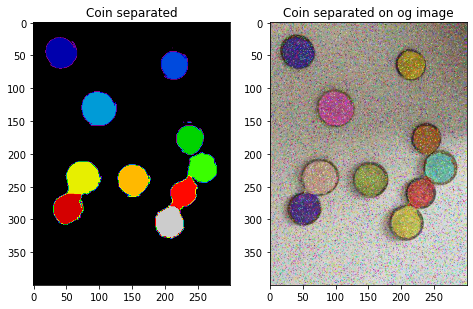

In [7]:
#Calculating distances
distance = ndimage.distance_transform_edt(im_bi2)
#Set size of kernel
size=13
#markers are created by taking local maxima of the distance to the background
local_maxi = peak_local_max(distance, footprint=np.ones((size,size)), labels=im_bi2)
#Creating mask based on distance
mask = np.zeros(distance.shape, dtype=bool)
#Turning zeroes to ones for transposed local maxima
mask[tuple(local_maxi.T)] = True
#Create markers variable
markers, _ = ndimage.label(mask)
#Create labels using watershed
labels = watershed(-distance, markers, mask=im_bi2)
#overlay labels on binary image
image_label_overlay = label2rgb(labels, image=im_bi2, bg_label=0)
#Plotting both images
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
plt.title('Coin separated')

plt.subplot(1,3,2)
plt.imshow(image_label_overlay+im_og)
plt.title('Coin separated on og image')

5. (5 points) Show your original image with an overlay of bounding boxes or circular boundaries of each 
coin you found. You can use the segmentation results (from Q2A.2) or the original imagee.

   **Display the resulting images with appropriate titles. Print the number of coins. Report the steps you took as comments in your code.**

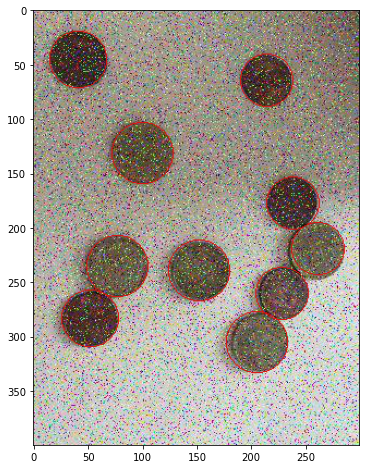

In [8]:

# Load picture and detect edges
ima = io.imread('2039830_coinimage.jpg')
imag=color.rgb2gray(ima)
#smaller kernel works better here
image=median(imag, disk(3))
#detect edges with canny and setting low thresholds
edges = feature.canny(image, sigma=2, low_threshold=0.0, high_threshold=0.1)

# Detect 10 radii
hough_radii = np.arange(20, 40, 2)
hough_res = hough_circle(edges, hough_radii)
#trial and error to detect right distances
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,min_xdistance = 39, min_ydistance = 39, total_num_peaks=10)

#Overlay the found circles over the original image
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
image_overlay = ima 
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image_overlay[circy, circx] = (220, 20, 20)

ax.imshow(image_overlay)
plt.show()

6. (8 points) The image contains 5 cents and 50 cents. Indicate the amount of money your code finds in the image. Show your original image with an overlay of green points on the centroids of 5 cents and red points on the centroids of 50 cents.
   **Display the resulting images with appropriate titles. Print the amount of money in the image. Report the steps you took as comments in your code.**

In [9]:
#5 cents have a smaller radius than 50 cents, thus they can be thresholded by radii



(<AxesSubplot:title={'center':'Image Gradient'}>,
 (-0.5, 299.5, 399.5, -0.5),
 Text(0.5, 1.0, 'Image Gradient'))

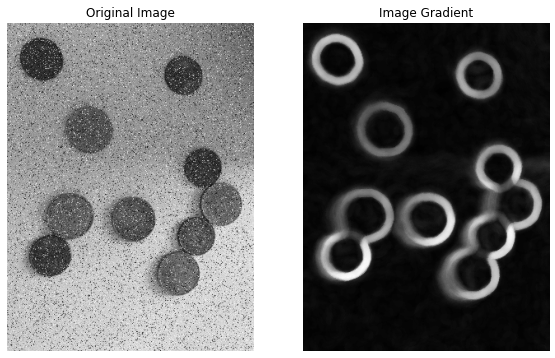

In [10]:
# Load picture 
im = img_as_ubyte(color.rgb2gray(io.imread('2039830_coinimage.jpg')))

# denoise image
denoised = rank.median(im, disk(7))

# Compute the gradient magnitude. The gradient is high at the borders of the objects and low (mostly) inside the objects.
im_gradient = rank.gradient(denoised, disk(5))


plt.figure(figsize=(15,8))
plt.subplot(131), plt.imshow(im, cmap='gray'), plt.axis('off'), plt.title('Original Image')
plt.subplot(132), plt.imshow(im_gradient, cmap='gray') , plt.axis('off'), plt.title('Image Gradient')



(-0.5, 299.5, 399.5, -0.5)

<Figure size 864x432 with 0 Axes>

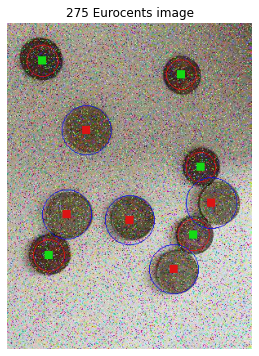

In [11]:

# Load picture and detect edges for smaller coins
ima = io.imread('2039830_coinimage.jpg')

# Detect edges with canny from the gradient and setting very low thresholds
edges = feature.canny(im_gradient, sigma=2.5, low_threshold=0.0, high_threshold=0.0001)

# Detect small radii for 5 cents coins
hough_radii = np.arange(15, 20, 1)
hough_res = hough_circle(edges, hough_radii)

# Trial and error to detect right distances
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=5, min_ydistance=60, total_num_peaks=5)

# Overlay the found circles over the original image
plt.figure(figsize=(12, 6))
image_overlay = ima.copy()  # Create a copy to avoid modifying the original image
for center_y, center_x, radius in zip(cy, cx, radii):
    # Draw circle
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=ima.shape)
    image_overlay[circy, circx] = (220, 20, 20)  # Red color for 5 cents circle
    #Chatgpt helped with creating the square in the circle center
    # Mark center with green point
    square_size = 5 
    image_overlay[max(0, center_y - square_size):min(ima.shape[0], center_y + square_size),
                  max(0, center_x - square_size):min(ima.shape[1], center_x + square_size)] = (20, 220, 20)
#Save circle amount
five_cents_amount = len(cx)

# Reload image and restart procedure for bigger coins and lower thresholds
ima = io.imread('2039830_coinimage.jpg')

edges = feature.canny(image, sigma=8, low_threshold=0.0, high_threshold=0.0000001)

# Detect big radii for 50 cents coins
hough_radii = np.arange(30, 35, 1)
hough_res = hough_circle(edges, hough_radii)

# Trial and error to detect right distances
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=50, min_ydistance=50, total_num_peaks=5)

# Overlay the found circles over the previous overlay
image_overlay2 = image_overlay.copy()
for center_y, center_x, radius in zip(cy, cx, radii):
    # Draw circle
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=ima.shape)
    image_overlay2[circy, circx] = (20, 20, 220)  # Blue color for 50 cents circle
    #Chatgpt helped with creating the square in the circle center
    # Mark center with red point
    square_size = 5 
    image_overlay2[max(0, center_y - square_size):min(ima.shape[0], center_y + square_size),
                   max(0, center_x - square_size):min(ima.shape[1], center_x + square_size)] = (220, 20, 20)
#Save circle amount
fifty_cents_amount = len(cx)

plt.figure(figsize=(14, 6))
plt.imshow(image_overlay2)
plt.title(f'{five_cents_amount*5 + fifty_cents_amount*50} Eurocents image')
plt.axis('off')
